## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import geopandas
import shapely.geometry as geom
import geoplot

#Install the extra libs with the following command: conda install -c conda-forge geoplot geopandas shapely

## Question:

### What are the riskiest COVID-19 infection-prone locations in Seoul (where infected people have been)? (Descriptive / Exploratory)

## Reading Data - Patient Route

#### [Dataset Description](https://www.kaggle.com/kimjihoo/ds4c-what-is-this-dataset-detailed-description)

In [2]:
patient_route = pd.read_csv('../../data/PatientRoute.csv')

### Taking a look at the data

In [3]:
patient_route.head(20)

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221
6,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.589590,127.009766
7,1000000002,5.0,2020-01-27,Seoul,Seongbuk-gu,restaurant,37.592057,127.018898
8,1000000002,5.0,2020-01-27,Seoul,Dongdaemun-gu,store,37.566262,127.065815
9,1000000002,5.0,2020-01-28,Seoul,Seongbuk-gu,etc,37.591669,127.018420


In [4]:
patient_route.describe()

,patient_id,global_num,latitude,longitude
count,5.963000e+03,3154.000000,5963.000000,5963.000000
mean,2.492088e+09,6303.317058,36.744703,127.627235
std,1.951605e+09,3590.101111,0.935144,0.908103
min,1.000000e+09,2.000000,33.454642,126.301005
25%,1.000000e+09,2818.000000,35.871435,126.940584
50%,1.100000e+09,7688.000000,37.342219,127.106542
75%,4.100000e+09,9080.500000,37.515846,128.597562
max,6.100000e+09,10659.000000,38.193169,129.475746


In [5]:
patient_route.describe(include=['object'])

,date,province,city,type
count,5963,5963,5963,5963
unique,89,16,149,23
top,2020-02-24,Seoul,Cheonan-si,hospital
freq,322,2256,465,1790


In [6]:
places_per_patient = patient_route.groupby('patient_id').type.count()

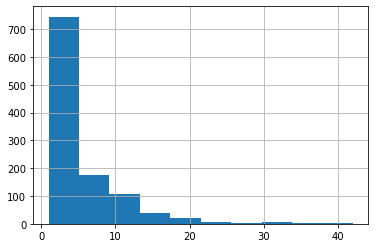

In [7]:
places_per_patient.hist();

### Most common places visited by infected people

In [8]:
def plot_categorical_col_dist(df, col_name, plot_title, first_n=-1):
    category_counts = df[col_name].value_counts()
    if (first_n != -1):
        category_counts = category_counts[:first_n]
    (category_counts/df.shape[0]).plot(kind="bar");
    plt.title(plot_title);

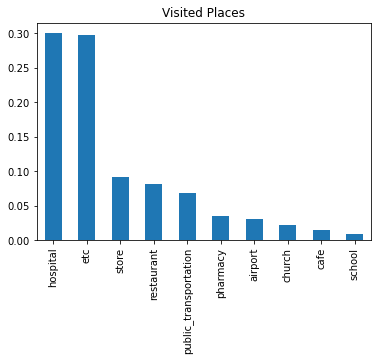

In [9]:
plot_categorical_col_dist(patient_route, 'type', 'Visited Places', 10)

### Visualize patient route stops on map

##### Analysis will be performed only for Seoul province

In [10]:
seoul_p_route = patient_route[patient_route['province'] == 'Seoul']
print(seoul_p_route.shape)
seoul_p_route.head()

(2256, 8)


,patient_id,global_num,date,province,city,type,latitude,longitude
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221


##### Adding fortnight info to date

In [11]:
def get_fortnight(date):
    if date <= '2020-01-31':
        return 'Jan-2'
    elif date <= '2020-02-15':
        return 'Feb-1'
    elif date <= '2020-02-28':
        return 'Feb-2'
    elif date <= '2020-03-15':
        return 'Mar-1'
    elif date <= '2020-03-31':
        return 'Mar-2'
    elif date <= '2020-04-15':
        return 'Apr-1'
    elif date <= '2020-05-01':
        return 'Apr-2'

seoul_p_route['fortnight'] = seoul_p_route.date.transform(lambda x: get_fortnight(x))

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
seoul_p_route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude,fortnight
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659,Jan-2
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048,Jan-2
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822,Jan-2
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534,Jan-2
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221,Jan-2


##### Encode geographic info

In [13]:
seoul_p_route['risk_location'] = list(zip(seoul_p_route.longitude, seoul_p_route.latitude))
seoul_p_route['risk_location'] = seoul_p_route['risk_location'].apply(geom.Point)
seoul_p_route_gdf = geopandas.GeoDataFrame(seoul_p_route, geometry='risk_location')

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Read Seoul Shape

In [14]:
seoul_shape = geopandas.read_file('../../data/shapefiles/seoul/seoul-maps/juso/2015/shp/seoul_neighborhoods.shp')

In [15]:
seoul_shape

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515..."
1,11110118,내수동,Naesu-dong,59,0.000007,0.011823,"POLYGON ((126.97318 37.57399, 126.97328 37.573..."
2,11590105,흑석동,Heukseok-dong,15,0.000171,0.057420,"POLYGON ((126.96639 37.51014, 126.96687 37.509..."
3,11320107,창동,Chang-dong,1,0.000436,0.100323,"POLYGON ((127.05147 37.66043, 127.05150 37.659..."
4,11230107,청량리동,Cheongnyangni-dong,8,0.000122,0.064774,"POLYGON ((127.04305 37.59696, 127.04361 37.596..."
...,...,...,...,...,...,...,...
462,11170133,서빙고동,Seobinggo-dong,461,0.000081,0.038065,"POLYGON ((126.99185 37.52515, 126.99187 37.525..."
463,11170134,주성동,Juseong-dong,462,0.000018,0.021908,"POLYGON ((126.99820 37.52448, 126.99838 37.524..."
464,11170122,문배동,Munbae-dong,442,0.000012,0.018005,"POLYGON ((126.97095 37.53772, 126.97095 37.537..."
465,11170103,용산동4가,Yongsan-dong 4(sa)-ga,447,0.000081,0.036409,"POLYGON ((126.98810 37.53433, 126.98816 37.534..."


##### Set the CRS of the points to the CRS of Seoul's shapefile

In [16]:
seoul_p_route_gdf.crs = seoul_shape.crs

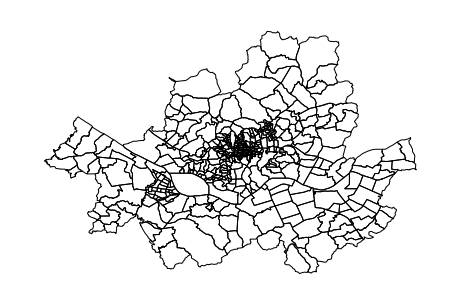

In [17]:
geoplot.polyplot(seoul_shape)

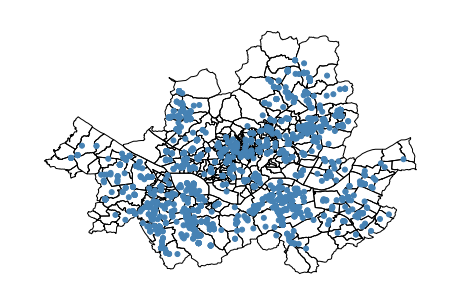

In [18]:
ax = geoplot.pointplot(seoul_p_route_gdf)
geoplot.polyplot(seoul_shape, ax=ax)

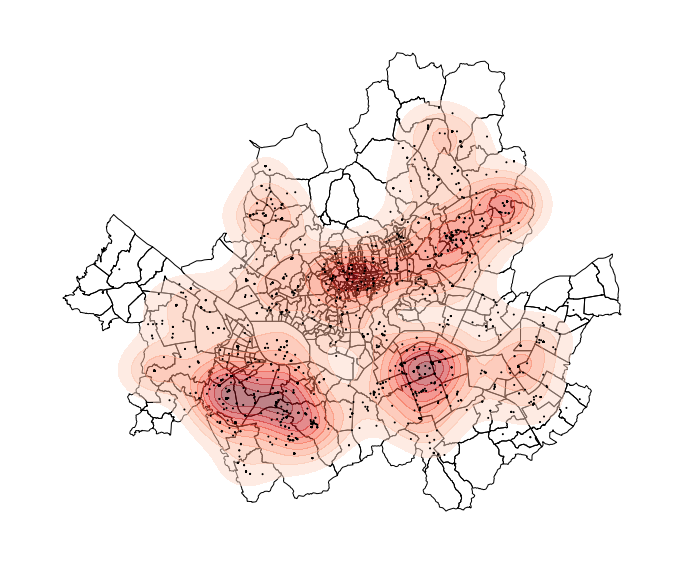

In [19]:
ax = geoplot.kdeplot(
    seoul_p_route_gdf, cmap='Reds', projection=geoplot.crs.WebMercator(), figsize=(12, 12),
    shade=True, alpha = 0.5
)
geoplot.pointplot(seoul_p_route_gdf, s=1, color='black', ax=ax);
geoplot.polyplot(seoul_shape, ax=ax);

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/geoplot/geoplot.py:1743: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  url=getattr(ctx.sources, provider), ll=True


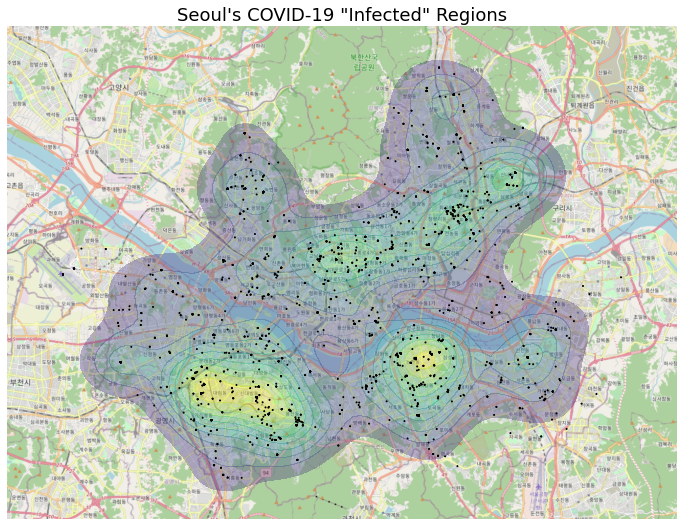

In [20]:
ax = geoplot.kdeplot(
    seoul_p_route_gdf, cmap='viridis', projection=geoplot.crs.WebMercator(), figsize=(12, 12), 
    alpha = 0.35, shade=True
)
geoplot.pointplot(seoul_p_route_gdf, s=1, color='black', ax=ax)
geoplot.webmap(seoul_p_route_gdf, ax=ax)
plt.title('Seoul\'s COVID-19 "Infected" Regions', fontsize=18);

In [21]:
def plot_kde_infected_areas(infected_places_df, axis, province=None, start_date=None, end_date=None, fortnight=None):
    filtered_inf_places_df = infected_places_df
    if (province != None):
        #print("Filtering by province: " + province)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['province'] == province]
    if (start_date != None):
        #print("Filtering by start date: " + start_date)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['date'] >= start_date]
    if (end_date != None):
        #print("Filtering by end date: " + end_date)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['date'] <= end_date]
    if (fortnight != None):
        #print("Filtering by fortnight: " + fortnight)
        filtered_inf_places_df = filtered_inf_places_df[filtered_inf_places_df['fortnight'] == fortnight]
    geoplot.kdeplot(filtered_inf_places_df, cmap='viridis', projection=geoplot.crs.WebMercator(), alpha = 0.35, shade=True, ax=axis)
    geoplot.pointplot(filtered_inf_places_df, s=2, color='black', ax=axis)
    geoplot.webmap(seoul_shape, ax=axis)
    province_title = ((province + ' ') if province != None else '')
    fortnight_title = ((' for ' + fortnight) if fortnight != None else '')
    axis.set_title(province_title + 'COVID-19 "Infected" Regions' + fortnight_title)
    #ax.title(province_title + 'COVID-19 "Infected" Regions' + fortnight_title, fontsize=10)

/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/local/tarciso/anaconda3/envs/udacity-ds-p1/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


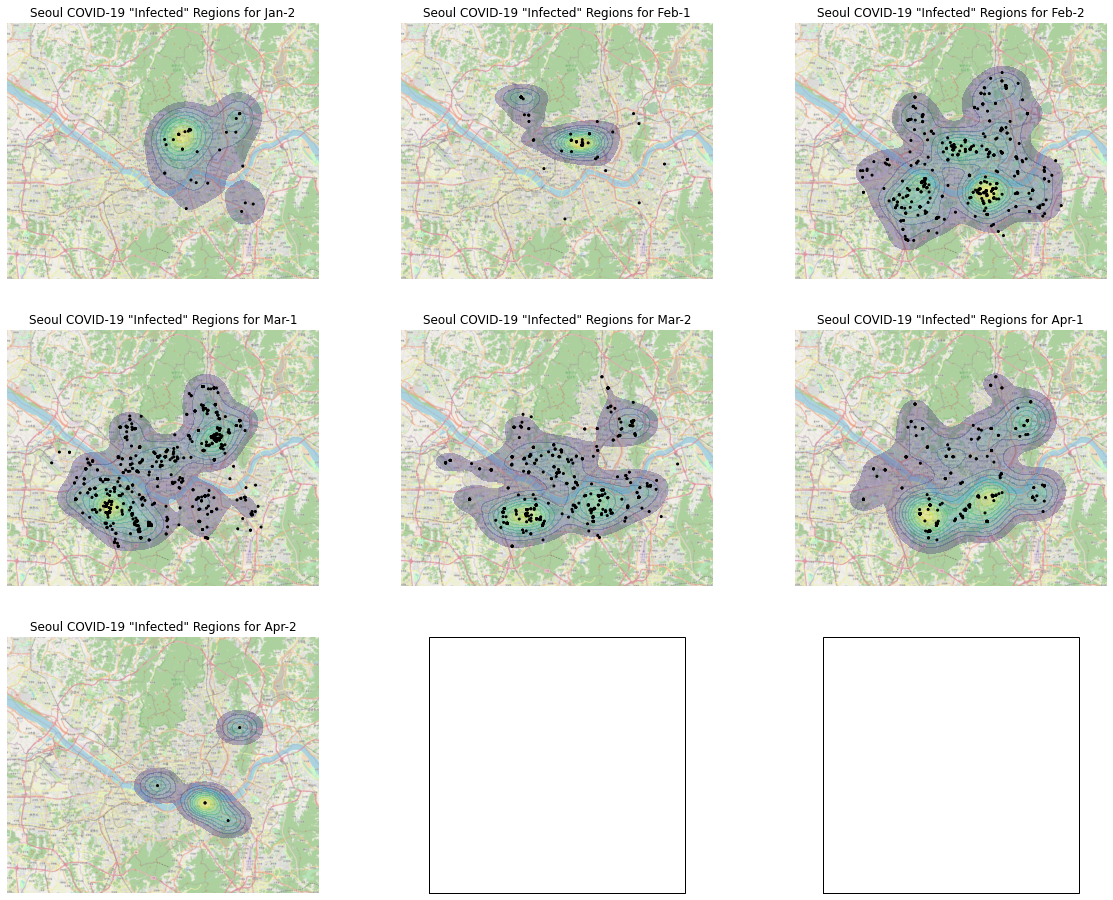

In [22]:
f, axes = plt.subplots(figsize=(20, 16), ncols=3, nrows=3,subplot_kw={'projection': geoplot.crs.WebMercator()})
#f, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=2,subplot_kw={'projection': geoplot.crs.WebMercator()})
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[0][0], province='Seoul', fortnight='Jan-2');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[0][1], province='Seoul', fortnight='Feb-1');
#plot_kde_infected_areas(patient_route_gdf, axis=axes[1][0], province='Seoul', fortnight='Feb-2');
#plot_kde_infected_areas(patient_route_gdf, axis=axes[1][1], province='Seoul', fortnight='Mar-1');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[0][2], province='Seoul', fortnight='Feb-2');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[1][0], province='Seoul', fortnight='Mar-1');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[1][1], province='Seoul', fortnight='Mar-2');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[1][2], province='Seoul', fortnight='Apr-1');
plot_kde_infected_areas(seoul_p_route_gdf, axis=axes[2][0], province='Seoul', fortnight='Apr-2');

plt.setp(axes, yticks=[])
plt.tight_layout()

##### Matching route places with Seoul shape neighborhoods

In [23]:
seoul_p_route_gdf.head()

,patient_id,global_num,date,province,city,type,latitude,longitude,fortnight,risk_location
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659,Jan-2,POINT (127.00566 37.56724)
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048,Jan-2,POINT (127.01705 37.59256)
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822,Jan-2,POINT (127.01682 37.59181)
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534,Jan-2,POINT (127.02953 37.56399)
5,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221,Jan-2,POINT (127.01522 37.59033)


In [24]:
seoul_shape.head()

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515..."
1,11110118,내수동,Naesu-dong,59,0.000007,0.011823,"POLYGON ((126.97318 37.57399, 126.97328 37.573..."
2,11590105,흑석동,Heukseok-dong,15,0.000171,0.057420,"POLYGON ((126.96639 37.51014, 126.96687 37.509..."
3,11320107,창동,Chang-dong,1,0.000436,0.100323,"POLYGON ((127.05147 37.66043, 127.05150 37.659..."
4,11230107,청량리동,Cheongnyangni-dong,8,0.000122,0.064774,"POLYGON ((127.04305 37.59696, 127.04361 37.596..."


In [25]:
seoul_risk_places_nbh_gdf = geopandas.sjoin(seoul_shape, seoul_p_route_gdf, op='intersects', how='left')

In [26]:
seoul_risk_places_nbh_gdf

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry,index_right,patient_id,global_num,date,province,city,type,latitude,longitude,fortnight
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",2192.0,1.000001e+09,10313.0,2020-04-06,Seoul,Dongjak-gu,hospital,37.498815,126.923930,Apr-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",1427.0,1.000000e+09,8446.0,2020-03-15,Seoul,Dongjak-gu,school,37.501597,126.922227,Mar-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",1441.0,1.000000e+09,8456.0,2020-03-15,Seoul,Dongjak-gu,school,37.501597,126.922227,Mar-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",758.0,1.000000e+09,7437.0,2020-02-29,Seoul,Dongjak-gu,etc,37.508096,126.926254,Mar-1
0,11590108,대방동,Daebang-dong,18,0.000157,0.063998,"POLYGON ((126.93240 37.51558, 126.93243 37.515...",4076.0,3.013000e+09,NaN,2020-02-22,Seoul,Dongjak-gu,public_transportation,37.512554,126.926371,Feb-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",2092.0,1.000001e+09,10186.0,2020-04-03,Seoul,Yongsan-gu,hospital,37.538427,126.965444,Apr-1
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",1236.0,1.000000e+09,7980.0,2020-03-09,Seoul,Yongsan-gu,etc,37.538427,126.965444,Mar-1
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",1458.0,1.000000e+09,8617.0,2020-03-19,Seoul,Yongsan-gu,hospital,37.538427,126.965444,Mar-2
466,11170112,원효로1가,Wonhyoro 1(iI)-ga,449,0.000021,0.020099,"POLYGON ((126.97052 37.54154, 126.97058 37.541...",1457.0,1.000000e+09,8617.0,2020-03-18,Seoul,Yongsan-gu,hospital,37.538427,126.965444,Mar-2


In [27]:
print(seoul_p_route_gdf.shape)
print(seoul_risk_places_nbh_gdf.shape)

(2256, 10)
(2492, 17)


In [28]:
seoul_risk_places_per_nbh = seoul_risk_places_nbh_gdf.groupby(['EMD_CD', 'EMD_KOR_NM','EMD_ENG_NM']) \
                                .agg({'index_right':lambda x: x.count()}) \
                                .reset_index() \
                                .rename(index=str, columns= {'index_right':'num_risk_places'})
seoul_risk_places_per_nbh = seoul_risk_places_per_nbh.merge(seoul_shape, on=['EMD_CD', 'EMD_KOR_NM','EMD_ENG_NM'])
seoul_risk_places_per_nbh_gdf = geopandas.GeoDataFrame(seoul_risk_places_per_nbh, geometry='geometry')
seoul_risk_places_per_nbh_gdf

,EMD_CD,EMD_KOR_NM,EMD_ENG_NM,num_risk_places,ESRI_PK,SHAPE_AREA,SHAPE_LEN,geometry
0,11110101,청운동,Cheongun-dong,0.0,42,0.000081,0.042186,"POLYGON ((126.97151 37.59368, 126.97157 37.593..."
1,11110102,신교동,Singyo-dong,0.0,43,0.000010,0.014906,"POLYGON ((126.96917 37.58584, 126.96914 37.585..."
2,11110103,궁정동,Gungjeong-dong,0.0,44,0.000007,0.013882,"POLYGON ((126.97386 37.58658, 126.97400 37.586..."
3,11110104,효자동,Hyoja-dong,0.0,52,0.000006,0.010860,"POLYGON ((126.97341 37.58355, 126.97350 37.583..."
4,11110105,창성동,Changseong-dong,0.0,53,0.000006,0.010103,"POLYGON ((126.97375 37.58110, 126.97377 37.580..."
...,...,...,...,...,...,...,...,...
462,11740106,둔촌동,Dunchon-dong,0.0,246,0.000251,0.080648,"POLYGON ((127.15671 37.53757, 127.15656 37.537..."
463,11740107,암사동,Amsa-dong,0.0,225,0.000479,0.100510,"POLYGON ((127.14432 37.55497, 127.14422 37.554..."
464,11740108,성내동,Seongnae-dong,24.0,205,0.000199,0.060985,"POLYGON ((127.12364 37.53895, 127.12365 37.538..."
465,11740109,천호동,Cheonho-dong,5.0,229,0.000312,0.093699,"POLYGON ((127.14272 37.55068, 127.14275 37.550..."


In [29]:
seoul_risk_places_per_nbh.dtypes

EMD_CD               object
EMD_KOR_NM           object
EMD_ENG_NM           object
num_risk_places     float64
ESRI_PK               int64
SHAPE_AREA          float64
SHAPE_LEN           float64
geometry           geometry
dtype: object

In [30]:
seoul_shape.shape

(467, 7)

##### Top Risky Neighborhoods

In [31]:
top_risk_nbhs = seoul_risk_places_per_nbh[['EMD_CD','geometry','EMD_KOR_NM','EMD_ENG_NM','num_risk_places']].sort_values('num_risk_places', ascending=False)
top_risk_nbhs

,EMD_CD,geometry,EMD_KOR_NM,EMD_ENG_NM,num_risk_places
363,11530102,"POLYGON ((126.89283 37.50347, 126.89276 37.503...",구로동,Guro-dong,147.0
236,11260106,"POLYGON ((127.11132 37.62070, 127.11216 37.620...",신내동,Sinnae-dong,102.0
434,11680105,"POLYGON ((127.06758 37.52231, 127.06761 37.521...",삼성동,Samseong-dong,81.0
418,11620101,"POLYGON ((126.92803 37.49503, 126.92823 37.494...",봉천동,Bongcheon-dong,80.0
417,11590109,"POLYGON ((126.92916 37.49844, 126.92924 37.498...",신대방동,Sindaebang-dong,80.0
...,...,...,...,...,...
169,11170109,"POLYGON ((126.96723 37.55075, 126.96735 37.550...",청파동1가,Cheongpa-dong 1(il)-ga,0.0
168,11170108,"POLYGON ((126.96919 37.55466, 126.96919 37.554...",서계동,Seogye-dong,0.0
163,11170103,"POLYGON ((126.98810 37.53433, 126.98816 37.534...",용산동4가,Yongsan-dong 4(sa)-ga,0.0
160,11140174,"POLYGON ((126.96578 37.55417, 126.96577 37.554...",만리동2가,Malli-dong 2(i)-ga,0.0


In [32]:
top_risk_nbhs['nbh_centroid'] = top_risk_nbhs['geometry'].apply(lambda x: geom.Point(x.representative_point().coords[:][0]))
top_risk_nbhs = geopandas.GeoDataFrame(top_risk_nbhs, geometry='nbh_centroid')
top_risk_nbhs.crs = seoul_shape.crs

In [33]:
top_risk_nbhs

,EMD_CD,geometry,EMD_KOR_NM,EMD_ENG_NM,num_risk_places,nbh_centroid
363,11530102,"POLYGON ((126.89283 37.50347, 126.89276 37.503...",구로동,Guro-dong,147.0,POINT (126.88242 37.49379)
236,11260106,"POLYGON ((127.11132 37.62070, 127.11216 37.620...",신내동,Sinnae-dong,102.0,POINT (127.09315 37.61024)
434,11680105,"POLYGON ((127.06758 37.52231, 127.06761 37.521...",삼성동,Samseong-dong,81.0,POINT (127.05531 37.51467)
418,11620101,"POLYGON ((126.92803 37.49503, 126.92823 37.494...",봉천동,Bongcheon-dong,80.0,POINT (126.95703 37.47500)
417,11590109,"POLYGON ((126.92916 37.49844, 126.92924 37.498...",신대방동,Sindaebang-dong,80.0,POINT (126.91723 37.49212)
...,...,...,...,...,...,...
169,11170109,"POLYGON ((126.96723 37.55075, 126.96735 37.550...",청파동1가,Cheongpa-dong 1(il)-ga,0.0,POINT (126.96706 37.54889)
168,11170108,"POLYGON ((126.96919 37.55466, 126.96919 37.554...",서계동,Seogye-dong,0.0,POINT (126.96646 37.55260)
163,11170103,"POLYGON ((126.98810 37.53433, 126.98816 37.534...",용산동4가,Yongsan-dong 4(sa)-ga,0.0,POINT (126.98557 37.53056)
160,11140174,"POLYGON ((126.96578 37.55417, 126.96577 37.554...",만리동2가,Malli-dong 2(i)-ga,0.0,POINT (126.96409 37.55429)


In [34]:
top_risk_nbhs.describe()

,num_risk_places
count,467.000000
mean,4.830835
std,13.147368
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,147.000000


### Creating a Choropleth to show the most risky neighborhoods

##### Defining Choropleth data breaks

In [35]:
import mapclassify
#scheme = mapclassify.NaturalBreaks(seoul_risk_places_per_nbh['num_risk_places'])
scheme = mapclassify.UserDefined(seoul_risk_places_per_nbh['num_risk_places'], bins=[5, 25, 50, 100])

In [36]:
scheme

UserDefined             

    Interval       Count
------------------------
[  0.00,   5.00] |   376
(  5.00,  25.00] |    69
( 25.00,  50.00] |    15
( 50.00, 100.00] |     5
(100.00, 147.00] |     2

In [37]:
top_risk_nbhs

,EMD_CD,geometry,EMD_KOR_NM,EMD_ENG_NM,num_risk_places,nbh_centroid
363,11530102,"POLYGON ((126.89283 37.50347, 126.89276 37.503...",구로동,Guro-dong,147.0,POINT (126.88242 37.49379)
236,11260106,"POLYGON ((127.11132 37.62070, 127.11216 37.620...",신내동,Sinnae-dong,102.0,POINT (127.09315 37.61024)
434,11680105,"POLYGON ((127.06758 37.52231, 127.06761 37.521...",삼성동,Samseong-dong,81.0,POINT (127.05531 37.51467)
418,11620101,"POLYGON ((126.92803 37.49503, 126.92823 37.494...",봉천동,Bongcheon-dong,80.0,POINT (126.95703 37.47500)
417,11590109,"POLYGON ((126.92916 37.49844, 126.92924 37.498...",신대방동,Sindaebang-dong,80.0,POINT (126.91723 37.49212)
...,...,...,...,...,...,...
169,11170109,"POLYGON ((126.96723 37.55075, 126.96735 37.550...",청파동1가,Cheongpa-dong 1(il)-ga,0.0,POINT (126.96706 37.54889)
168,11170108,"POLYGON ((126.96919 37.55466, 126.96919 37.554...",서계동,Seogye-dong,0.0,POINT (126.96646 37.55260)
163,11170103,"POLYGON ((126.98810 37.53433, 126.98816 37.534...",용산동4가,Yongsan-dong 4(sa)-ga,0.0,POINT (126.98557 37.53056)
160,11140174,"POLYGON ((126.96578 37.55417, 126.96577 37.554...",만리동2가,Malli-dong 2(i)-ga,0.0,POINT (126.96409 37.55429)


In [63]:
top_risk_nbhs.head(1).centroid

363    126.882417
dtype: float64

In [79]:
type(top_risk_nbhs.EMD_ENG_NM.head(1))

pandas.core.series.Series

Text(363    126.882417
dtype: float64, 363    37.493785
dtype: float64, 'Guro-dong')

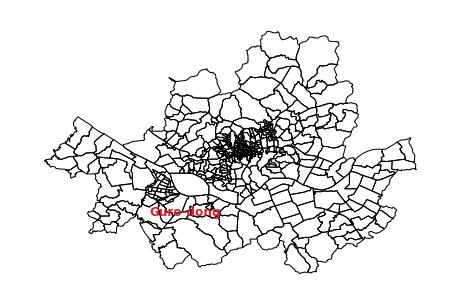

In [85]:
ax = geoplot.polyplot(seoul_shape);

ax.annotate('Guro-dong',
            xy=(top_risk_nbhs.head(1).centroid.x,top_risk_nbhs.head(1).centroid.y),
            fontsize=12, 
            fontweight="bold",
            color='#D3212D')

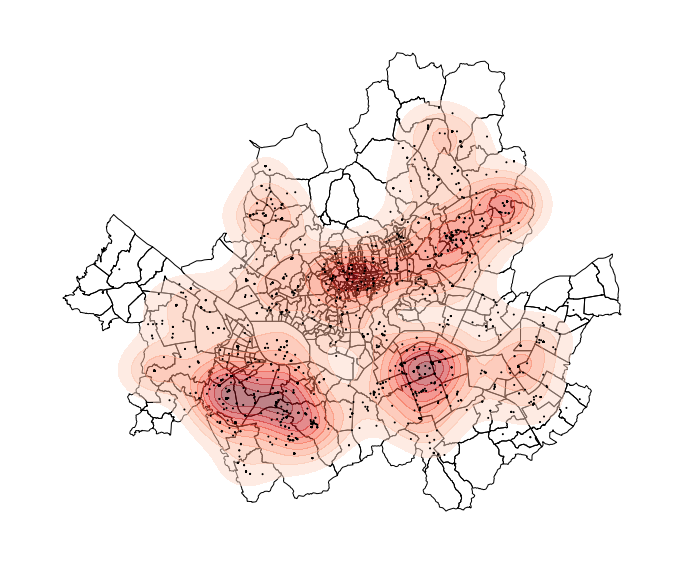

In [106]:
ax = geoplot.kdeplot(
    seoul_p_route_gdf, cmap='Reds', projection=geoplot.crs.WebMercator(), figsize=(12, 12),
    shade=True, alpha = 0.5
)

ax.annotate('Guro-dong',
            xy=(top_risk_nbhs.head(1).centroid.x,top_risk_nbhs.head(1).centroid.y),
            clip_on=True,
            fontsize=12, 
            fontweight="bold",
            color='#D3212D')

geoplot.pointplot(seoul_p_route_gdf, s=1, color='black', ax=ax);
geoplot.polyplot(seoul_shape, ax=ax);


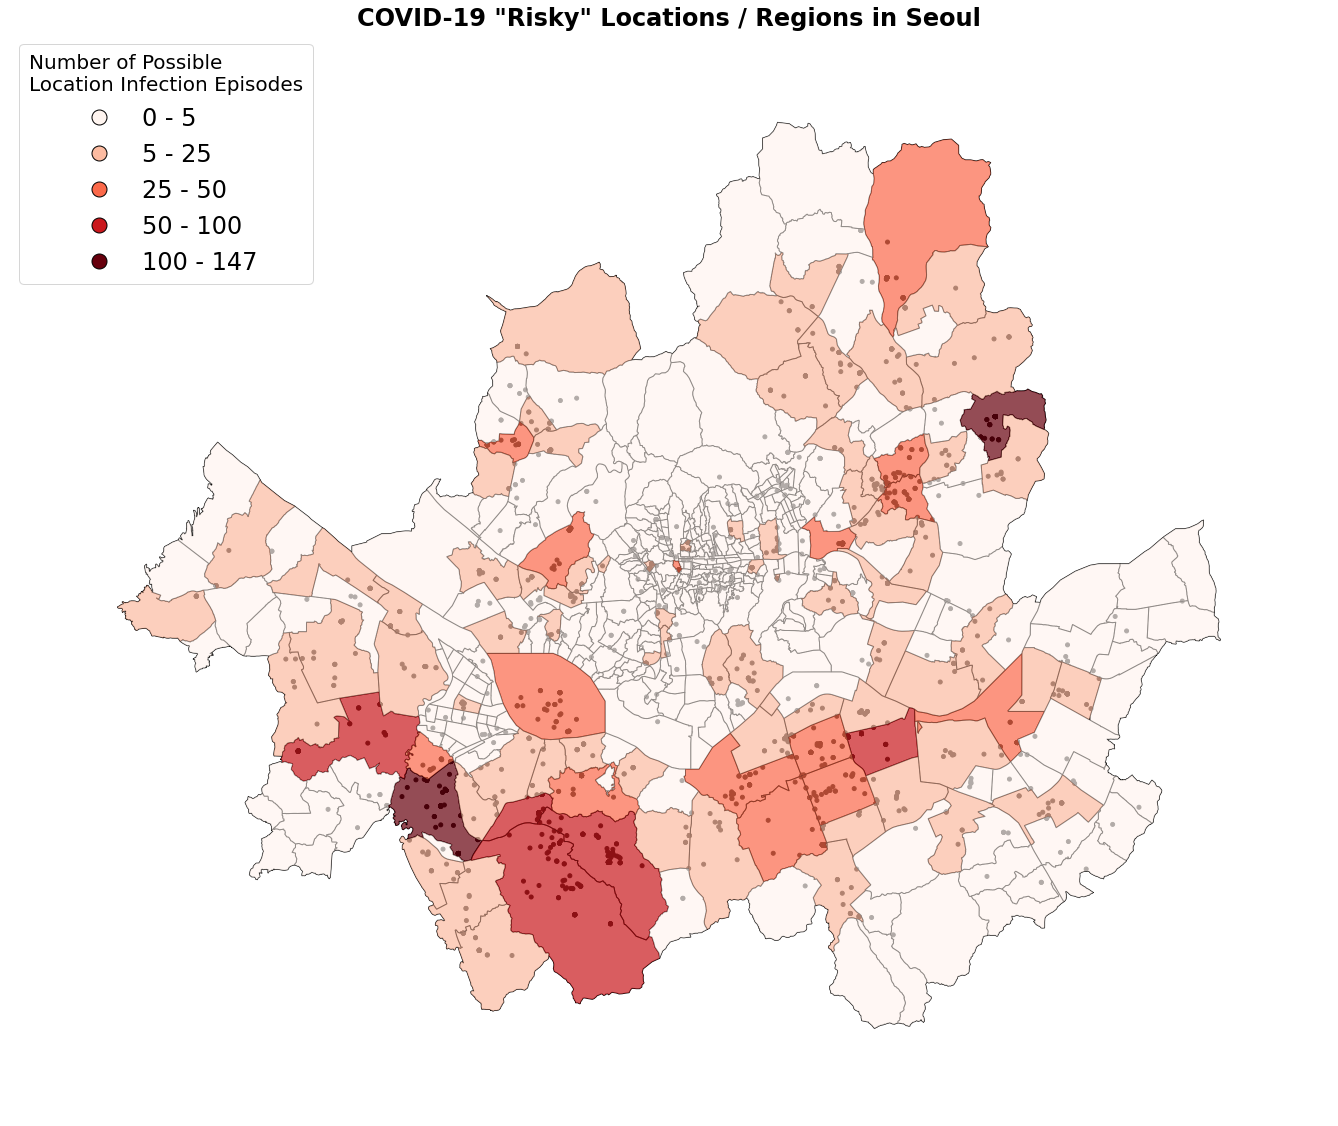

In [139]:
f, axis = plt.subplots(figsize=(30, 20),subplot_kw={'projection': geoplot.crs.WebMercator()})

geoplot.choropleth(
    seoul_risk_places_per_nbh_gdf, 
    hue=seoul_risk_places_per_nbh_gdf.num_risk_places, 
    scheme=scheme,
    cmap='Reds', 
    legend=True, 
    projection=geoplot.crs.WebMercator(), 
    alpha=0.7,ax = axis,
    legend_kwargs={'title': 'Number of Possible\nLocation Infection Episodes',
                   'fontsize': 24, 'markersize':15,
                   'markeredgecolor':'black',
                   'title_fontsize': 20,
                   'loc':'upper left'}    
)

#ax = geoplot.polyplot(seoul_shape);

axis.annotate('Guro-dong',
            xy=(top_risk_nbhs.head(1).centroid.x,top_risk_nbhs.head(1).centroid.y),
            clip_on=True,
            fontsize=12, 
            fontweight="bold",
            color='#000000')

geoplot.pointplot(seoul_p_route_gdf, s=4, color='black', ax=axis)
#geoplot.pointplot(top_risk_nbhs.head(10), s=4, color='black', ax=ax);
geoplot.polyplot(seoul_shape, ax=axis);


#for x, y, label in zip(top_risk_nbhs.geometry.x, top_risk_nbhs.geometry.y, top_risk_nbhs.EMD_ENG_NM):
#ax.annotate('Test Label', xy=(x, y), xytext=(3, 3), textcoords="offset points", clip_on=True)

axis.set_title('COVID-19 "Risky" Locations / Regions in Seoul', fontsize=24, fontweight="bold");
    
# for i, geo in top_risk_nbhs.nbh_centroid.iteritems():
#     ax.annotate(s=i, xy=[geo.x, geo.y], color="red", clip_on=True)


# for idx, row in top_risk_nbhs.iterrows():
#     plt.annotate(s=row['EMD_ENG_NM'], xy=row['nbh_centroid'], horizontalalignment='center')

In [140]:
f.savefig("../../assets/q3-seoul-risky-locs.png", bbox_inches='tight', dpi=600)

In [39]:
top5_risk_nbhs = top_risk_nbhs.head(5)[['EMD_KOR_NM','EMD_ENG_NM','num_risk_places']] \
                    .rename(index=str, columns={'EMD_KOR_NM':'NBHD_KOREAN','EMD_ENG_NM':'NBHD_ENGLISH',
                                                'num_risk_places':'LOC_INF_EPS'}) \
                    .reset_index(drop=True)
top5_risk_nbhs

,NBHD_KOREAN,NBHD_ENGLISH,LOC_INF_EPS
0,구로동,Guro-dong,147.0
1,신내동,Sinnae-dong,102.0
2,삼성동,Samseong-dong,81.0
3,봉천동,Bongcheon-dong,80.0
4,신대방동,Sindaebang-dong,80.0


In [40]:
top10_risk_nbhs = top_risk_nbhs.assign(RANK = range(1, len(top_risk_nbhs) + 1)) \
                     .head(10)[['RANK','EMD_KOR_NM','EMD_ENG_NM','num_risk_places']] \
                     .rename(index=str, columns={'EMD_KOR_NM':'NBHD_KOREAN','EMD_ENG_NM':'NBHD_ENGLISH',
                                                 'num_risk_places':'LOC_INF_EPS'}) \
                     .reset_index(drop=True)
top10_risk_nbhs

,RANK,NBHD_KOREAN,NBHD_ENGLISH,LOC_INF_EPS
0,1,구로동,Guro-dong,147.0
1,2,신내동,Sinnae-dong,102.0
2,3,삼성동,Samseong-dong,81.0
3,4,봉천동,Bongcheon-dong,80.0
4,5,신대방동,Sindaebang-dong,80.0
5,6,신정동,Sinjeong-dong,68.0
6,7,신림동,Sillim-dong,66.0
7,8,신천동,Sincheon-dong,49.0
8,9,서초동,Seocho-dong,48.0
9,10,논현동,Nonhyeon-dong,45.0
